# Simple Sentence Similarity (from github) - with application of the methods to a sample dataset at the end

Word embeddings have become widespread in Natural Language Processing. They allow us to easily compute the semantic similarity between two words, or to find the words most similar to a target word. However, in many applications we're more interested in the similarity between two sentences or short texts. In this notebook, I compare some simple ways of computing sentence similarity and investigate how they perform.

## Data

### STS Benchmark

The STS Benchmark brings together the English data from the SemEval sentence similarity tasks between 2012 and 2017. The data is split in training, development and test data: http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark


In [30]:
import pandas as pd
import numpy as np
import scipy
import math
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

def load_sts_dataset(filename):
    # Loads a subset of the STS dataset into a DataFrame. In particular both
    # sentences and their human rated similarity score.
    sent_pairs = []
    with tf.gfile.GFile(filename, "r") as f:
        for line in f:
            ts = line.strip().split("\t")
            sent_pairs.append((ts[5], ts[6], float(ts[4])))
    return pd.DataFrame(sent_pairs, columns=["sent_1", "sent_2", "sim"])


def download_and_load_sts_data():
    sts_dataset = tf.keras.utils.get_file(
        fname="Stsbenchmark.tar.gz",
        origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
        extract=True)

    sts_dev = load_sts_dataset(os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"))
    sts_test = load_sts_dataset(os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"))

    return sts_dev, sts_test

sts_dev, sts_test = download_and_load_sts_data()

In [31]:
sts_test[:5]

,sent_1,sent_2,sim
0,A girl is styling her hair.,A girl is brushing her hair.,2.5
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.6
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.0
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.2
4,A man is playing a harp.,A man is playing a keyboard.,1.5


### SICK data

The SICK dataset contains 10,000 English sentence pairs labelled with their semantic relatedness and entailment relation.

In [32]:
import requests

def download_sick(f): 

    response = requests.get(f).text

    lines = response.split("\n")[1:]
    lines = [l.split("\t") for l in lines if len(l) > 0]
    lines = [l for l in lines if len(l) == 5]

    df = pd.DataFrame(lines, columns=["idx", "sent_1", "sent_2", "sim", "label"])
    df['sim'] = pd.to_numeric(df['sim'])
    return df
    
sick_train = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_train.txt")
sick_dev = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_trial.txt")
sick_test = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_test_annotated.txt")
sick_all = sick_train.append(sick_test).append(sick_dev)

In [4]:
sick_all[:5]

,idx,sent_1,sent_2,sim,label
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL


## Preparation

First we need to do some preparation: some of our models require the sentences to be tokenized, some do not. For that reason we'll make a simple Sentence class where we keep both the raw sentence and the tokenized sentence. The individual methods below will then pick the input they need.

In [5]:
import nltk

STOP = set(nltk.corpus.stopwords.words("english"))

class Sentence:
    
    def __init__(self, sentence):
        self.raw = sentence
        normalized_sentence = sentence.replace("‘", "'").replace("’", "'")
        self.tokens = [t.lower() for t in nltk.word_tokenize(normalized_sentence)]
        self.tokens_without_stop = [t for t in self.tokens if t not in STOP]

Next, we're going to use the popular [Gensim](https://radimrehurek.com/gensim/) library to load aset of widely used pre-trained word embeddings: 
[word2vec](https://www.tensorflow.org/tutorials/word2vec) 

In [6]:
import gensim

from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec

PATH_TO_WORD2VEC = os.path.expanduser("/home/trickster_ks/jupy/GoogleNews-vectors-negative300.bin")
word2vec = gensim.models.KeyedVectors.load_word2vec_format(PATH_TO_WORD2VEC, binary=True, limit=500000)

Finally, in order to compute weighted averages of word embeddings later, we are going to load a file with word frequencies. These word frequencies have been collected from Wikipedia and saved in a tab-separated file. 

In [7]:
import csv

PATH_TO_FREQUENCIES_FILE = "frequencies/sentence_similarity/frequencies.tsv"
PATH_TO_DOC_FREQUENCIES_FILE = "frequencies/sentence_similarity/doc_frequencies.tsv"

def read_tsv(f):
    frequencies = {}
    with open(f) as tsv:
        tsv_reader = csv.reader(tsv, delimiter="\t")
        for row in tsv_reader: 
            frequencies[row[0]] = int(row[1])
        
    return frequencies
        
frequencies = read_tsv(PATH_TO_FREQUENCIES_FILE)
doc_frequencies = read_tsv(PATH_TO_DOC_FREQUENCIES_FILE)
doc_frequencies["NUM_DOCS"] = 1288431


## Similarity methods

### Baseline

As our baseline, we're going for the simplest way of computing sentence embeddings: just take the embeddings of the words in the sentence (minus the stopwords), and compute their average, weighted by the sentence frequency of each word. 

We then use the cosine to calculate the similarity between two sentence embeddings.

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import math

def run_avg_benchmark(sentences1, sentences2, model=None, use_stoplist=False, doc_freqs=None): 

    if doc_freqs is not None:
        N = doc_freqs["NUM_DOCS"]
    
    sims = []
    for (sent1, sent2) in zip(sentences1, sentences2):
    
        tokens1 = sent1.tokens_without_stop if use_stoplist else sent1.tokens
        tokens2 = sent2.tokens_without_stop if use_stoplist else sent2.tokens

        tokens1 = [token for token in tokens1 if token in model]
        tokens2 = [token for token in tokens2 if token in model]
        
        if len(tokens1) == 0 or len(tokens2) == 0:
            sims.append(0)
            continue
        
        tokfreqs1 = Counter(tokens1)
        tokfreqs2 = Counter(tokens2)
        
        weights1 = [tokfreqs1[token] * math.log(N/(doc_freqs.get(token, 0)+1)) 
                    for token in tokfreqs1] if doc_freqs else None
        weights2 = [tokfreqs2[token] * math.log(N/(doc_freqs.get(token, 0)+1)) 
                    for token in tokfreqs2] if doc_freqs else None
        
        if weights1 and weights2:
            if sum(weights1) == 0 or sum(weights2) == 0:
                sims.append(0)
                continue
        embedding1 = np.average([model[token] for token in tokfreqs1], axis=0, weights=weights1).reshape(1, -1)
        embedding2 = np.average([model[token] for token in tokfreqs2], axis=0, weights=weights2).reshape(1, -1)

        sim = cosine_similarity(embedding1, embedding2)[0][0]
        sims.append(sim)

    return sims

### Word Mover's Distance

Word mover's distance is a popular alternative to the simple average embedding similarity. The Word Mover's Distance uses the word embeddings of the words in two texts to measure the minimum amount that the words in one text need to "travel" in semantic space to reach the words of the other text. Word mover's distance is available in the popular Gensim library.

In [9]:
def run_wmd_benchmark(sentences1, sentences2, model, use_stoplist=False):
    
    sims = []
    for (sent1, sent2) in zip(sentences1, sentences2):
    
        tokens1 = sent1.tokens_without_stop if use_stoplist else sent1.tokens
        tokens2 = sent2.tokens_without_stop if use_stoplist else sent2.tokens
        
        tokens1 = [token for token in tokens1 if token in model]
        tokens2 = [token for token in tokens2 if token in model]
        
        if len(tokens1) == 0 or len(tokens2) == 0:
            tokens1 = [token for token in sent1.tokens if token in model]
            tokens2 = [token for token in sent2.tokens if token in model]
            
        sims.append(-model.wmdistance(tokens1, tokens2))
        
    return sims

### Smooth Inverse Frequency

Taking the average of the word embeddings in a sentence, like we did above, is a very crude method of computing sentence embeddings. Most importantly, this gives far too much weight to words that are quite irrelevant, semantically speaking. Smooth Inverse Frequency tries to solve this problem. 

To compute SIF sentence embeddings, we first compute a weighted average of the token embeddings in the sentence. This procedure is very similar to the weighted average we used above, with the single difference that the word embeddings are weighted by `a/a+p(w)`, where `w` is a parameter that is set to `0.001` by default, and `p(w)` is the estimated relative frequency of a word in a reference corpus.

Next, we need to perform common component removal: we compute the principal component of the sentence embeddings we obtained above and subtract from them their projections on this first principal component. This corrects for the influence of high-frequency words that mostly have a syntactic or discourse function, such as "just", "there", "but", etc. 

In [10]:
from sklearn.decomposition import TruncatedSVD

def remove_first_principal_component(X):
    svd = TruncatedSVD(n_components=1, n_iter=7, random_state=0)
    svd.fit(X)
    pc = svd.components_
    XX = X - X.dot(pc.transpose()) * pc
    return XX


def run_sif_benchmark(sentences1, sentences2, model, freqs={}, use_stoplist=False, a=0.001): 
    total_freq = sum(freqs.values())
    embeddings = []
    
    # SIF requires us to first collect all sentence embeddings and then perform 
    # common component analysis.
    for (sent1, sent2) in zip(sentences1, sentences2): 
        
        tokens1 = sent1.tokens_without_stop if use_stoplist else sent1.tokens
        tokens2 = sent2.tokens_without_stop if use_stoplist else sent2.tokens   
        
        tokens1 = [token for token in tokens1 if token in model]
        tokens2 = [token for token in tokens2 if token in model]
        
        if tokens1 == []: tokens1 = ['empty']
        if tokens2 == []: tokens2 = ['empty'] 
        
        weights1 = [a/(a+freqs.get(token,0)/total_freq) for token in tokens1]
        weights2 = [a/(a+freqs.get(token,0)/total_freq) for token in tokens2]
        
        embedding1 = np.average([model[token] for token in tokens1], axis=0, weights=weights1)
        embedding2 = np.average([model[token] for token in tokens2], axis=0, weights=weights2)
        embeddings.append(embedding1)
        embeddings.append(embedding2)

            
        
        
    embeddings = remove_first_principal_component(np.array(embeddings))
    sims = [cosine_similarity(embeddings[idx*2].reshape(1, -1), 
                              embeddings[idx*2+1].reshape(1, -1))[0][0] 
            for idx in range(int(len(embeddings)/2))]

    return sims

The methods above share two important characteristics: 

- As simple bag-of-word methods, they do take not word order into account.
- The word embeddings they use have been learned in an unsupervised manner. 

Both these characteristics are potential downsides: 

- Since differences in word order can point to differences in meaning (compare `the dog bites the man` with `the man bites the dog`), we'd like our sentence embeddings to be sensitive to this variation.
- Supervised training can help sentence embeddings learn the meaning of a sentence more directly.

We can achieve both points by using a pre-trained sentence encoder to produce our sentence embeddings. Several such encoders are available. We'll investigate InferSent and the Google Sentence Encoder.

## Experiments

Finally, it's time to run the actual experiments. 

In [11]:
def run_experiment(df, benchmarks): 
    
    sentences1 = [Sentence(s) for s in df['sent_1']]
    sentences2 = [Sentence(s) for s in df['sent_2']]
    
    pearson_cors, spearman_cors = [], []
    for label, method in benchmarks:
        sims = method(sentences1, sentences2)
        pearson_correlation = scipy.stats.pearsonr(sims, df['sim'])[0]
        print(label, pearson_correlation)
        pearson_cors.append(pearson_correlation)
        spearman_correlation = scipy.stats.spearmanr(sims, df['sim'])[0]
        spearman_cors.append(spearman_correlation)
        
    return pearson_cors, spearman_cors

In [12]:
import functools as ft

benchmarks = [("AVG-W2V", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=False)),
              ("AVG-W2V-STOP", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=True)),
              ("AVG-W2V-TFIDF", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=False, doc_freqs=doc_frequencies)),
              ("AVG-W2V-TFIDF-STOP", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=True, doc_freqs=doc_frequencies)),
              ("WMD-W2V", ft.partial(run_wmd_benchmark, model=word2vec, use_stoplist=False)), 
              ("SIF-W2V", ft.partial(run_sif_benchmark, freqs=frequencies, model=word2vec, use_stoplist=False)),
             ]

global PYEMD_EXT
pearson_results, spearman_results = {}, {}
pearson_results["SICK-DEV"], spearman_results["SICK-DEV"] = run_experiment(sick_dev, benchmarks)

AVG-W2V 0.7160297131633951
AVG-W2V-STOP 0.7006594956785003
AVG-W2V-TFIDF 0.7087075918706278
AVG-W2V-TFIDF-STOP 0.6976394325608488
WMD-W2V 0.6475827561855909
SIF-W2V 0.7248373288728335


## Results

Let's take a look at our results. We'll mostly work with Pearson correlation, as is standard in the literature, except where Spearman correlation sheds additional light on our findings.

In [13]:
plt.rcParams['figure.figsize'] = (10,5)

pearson_results_df = pd.DataFrame(pearson_results)
pearson_results_df = pearson_results_df.transpose()
pearson_results_df = pearson_results_df.rename(columns={i:b[0] for i, b in enumerate(benchmarks)})

spearman_results_df = pd.DataFrame(spearman_results)
spearman_results_df = spearman_results_df.transpose()
spearman_results_df = spearman_results_df.rename(columns={i:b[0] for i, b in enumerate(benchmarks)})



### Baselines

- Simple word2vec embeddings outperform GloVe embeddings.
- With word2vec, it's unclear whether using a stoplist or tf-idf weighting helps. With STS it sometimes does; with SICK it does not. Simply computing an unweighted average of all word2vec embeddings consistently performs pretty well.
- With GloVe, using a stoplist looks like a very good idea. Using tf-idf weights does not help, with or without a stoplist.

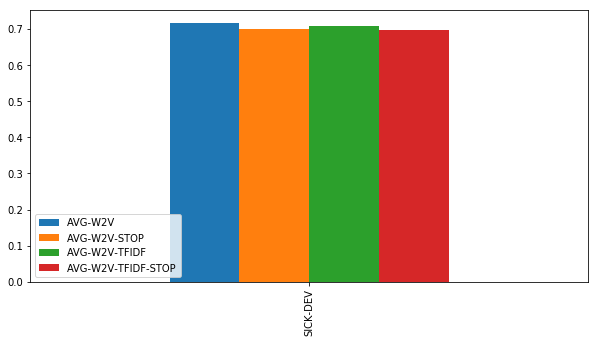

In [14]:
pearson_results_df[[b[0] for b in benchmarks if b[0].startswith("AVG")]].plot(kind="bar").legend(loc="lower left")

### Word Mover's Distance

Based on our results, there's little reason to use Word Mover's Distance rather than simple word2vec averages. Only on STS-TEST, and only in combination with a stoplist, does WMD clearly leave the baselines behind.

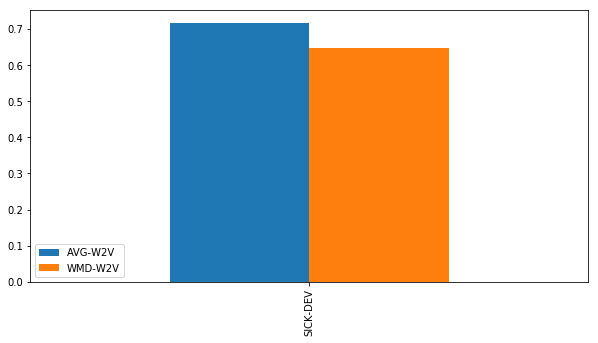

In [15]:
pearson_results_df[["AVG-W2V", "WMD-W2V"]].plot(kind="bar").legend(loc="lower left")

### Smooth Inverse Frequency

Smooth Inverse Frequency is the most consistent performer in our tests. On the SICK data, it does about as well as its baseline competitors, on STS it outranks them by a clear margin. Note there is little difference between SIF with word2vec embeddings and SIF with GloVe embeddings. This is remarkable, given the large differences we observed above. It shows SIF's weighting and common component removal is a very effective alternative to using a stoplist.

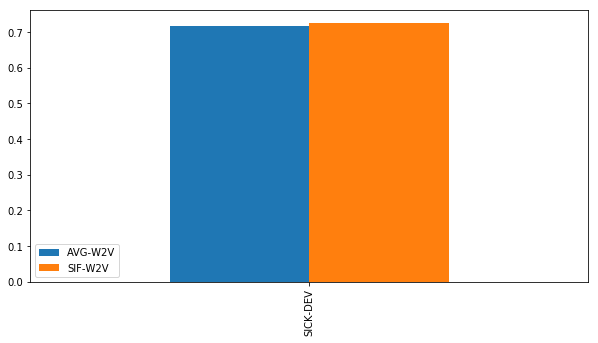

In [16]:
pearson_results_df[["AVG-W2V", "SIF-W2V"]].plot(kind="bar").legend(loc="lower left")

### Pretrained encoders

Pre-trained encoders have a lot to be said for them. However, our results indicate they are not yet able to capitalize fully on their training regime. Throughout our tests, Google's Sentence Encoder looks like a better choice than InferSent. However, the Pearson correlation coefficient shows very little difference with Smooth Inverse Frequency. The differences in Spearman correlation are more outspoken. This may indicate that the Google Sentence Encoder more often gets the relative ordering of the sentences right, but not necessarily the relative differences between them.

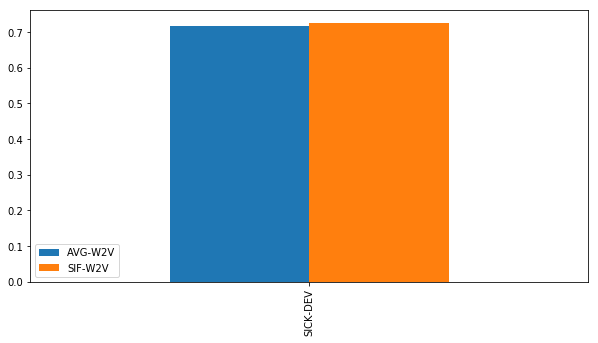

In [17]:
pearson_results_df[["AVG-W2V", "SIF-W2V"]].plot(kind="bar").legend(loc="lower left")

## Conclusions

These are the most important conclusions:

- When you're computing sentence similarity, word2vec embeddings are a safer choice than GloVe embeddings.
- Although an unweighted average of the word embeddings in the sentence holds its own as a simple baseline, Smooth Inverse Frequency is usually a stronger alternative.
- When you can use a pre-trained encoder, pick Google's Sentence Encoder, but remember its performance gain may not be all that spectacular.

### Putting it all together

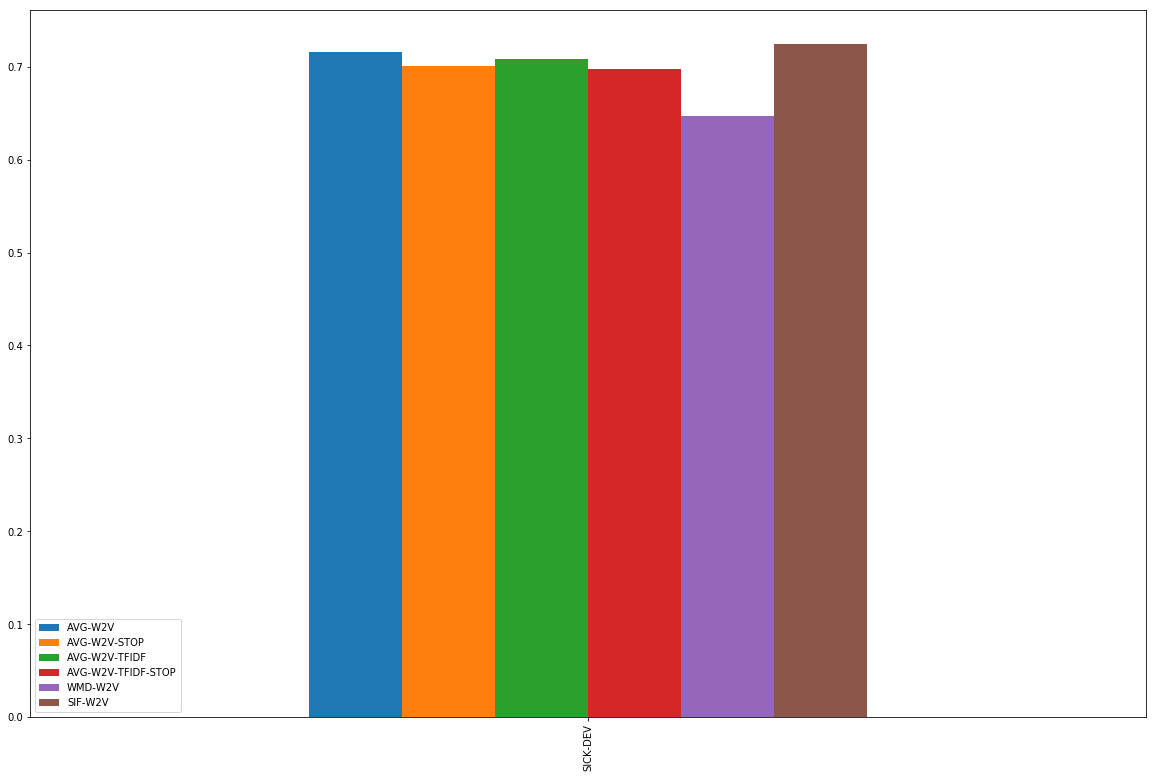

In [18]:
plt.rcParams['figure.figsize'] = (20,13)
pearson_results_df.plot(kind="bar").legend(loc="lower left")

# Application to our dataset - simple version

In [19]:
data = pd.read_csv('Example_dataset_marble - 5_column_with_correct.csv')

## simple version

In [20]:
def run_all_simple(df, benchmarks): 
    sentences1 = [Sentence(s) for s in df['Field_en']]
    sentences2 = [Sentence(s) for s in df['Field_correct_en']]
    sims = {"Sent1":sentences1, "Sent2": sentences2}
    pearson_cors, spearman_cors = [], []
    for label, method in benchmarks:
        sims[label] = method(sentences1, sentences2)

    frame = pd.DataFrame(sims)
    frame['Field_en'] = df['Field_en']
    frame['Field_correct_en'] = df['Field_correct_en']
    return frame

In [21]:
exp_frame = data.copy()
exp_frame.tail()

,Field,Field_correct,Field_en,Field_correct_en,Accuracy_score,Code,Fieldname
1780,een kanaal dat het afstand verkort,Suez kanaal gegraven,a channel that shortens the distance,Suez canal dug,4,g,Suez;Field4
1781,gewenning aan geld en luxe,Suez kanaal gegraven,habituation to money and luxury,Suez canal dug,0,c,Suez;Field4
1782,veel afstanden verkort,Suez kanaal gegraven,many distances shortened,Suez canal dug,0,c,Suez;Field4
1783,zeemiles minder,Suez kanaal gegraven,zeemiles less,Suez canal dug,0,c,Suez;Field4
1784,suezkanaal geopend als scheepsweg in 1842,Suez kanaal gegraven,Suez Canal opened in 1842 scheepsweg,Suez canal dug,4,g,Suez;Field4


In [22]:
exp_frame[exp_frame['Field_en'].str.strip() == '']

,Field,Field_correct,Field_en,Field_correct_en,Accuracy_score,Code,Fieldname


In [23]:
frame_sim = run_all_simple(exp_frame, benchmarks)

In [24]:
frame_sim = pd.concat([frame_sim, exp_frame[["Accuracy_score","Code","Fieldname"]]], axis=1)

In [25]:
frame_sim = frame_sim[['Fieldname', "Field_en",'Field_correct_en','AVG-W2V', 'AVG-W2V-STOP', 'AVG-W2V-TFIDF', 'AVG-W2V-TFIDF-STOP',
                 'WMD-W2V','SIF-W2V', 'Accuracy_score','Code']]
frame_sim.tail()

,Fieldname,Field_en,Field_correct_en,AVG-W2V,AVG-W2V-STOP,AVG-W2V-TFIDF,AVG-W2V-TFIDF-STOP,WMD-W2V,SIF-W2V,Accuracy_score,Code
1780,Suez;Field4,a channel that shortens the distance,Suez canal dug,0.175378,0.137159,0.070576,0.065852,-3.776180,-0.060223,4,g
1781,Suez;Field4,habituation to money and luxury,Suez canal dug,0.123385,0.123385,0.077991,0.077991,-4.183061,-0.118579,0,c
1782,Suez;Field4,many distances shortened,Suez canal dug,0.088644,0.088644,0.072981,0.072981,-4.071792,-0.120163,0,c
1783,Suez;Field4,zeemiles less,Suez canal dug,-0.012983,-0.012983,-0.013315,-0.013315,-3.844988,-0.207510,0,c
1784,Suez;Field4,Suez Canal opened in 1842 scheepsweg,Suez canal dug,0.680551,0.727537,0.735163,0.736865,-2.248285,0.674884,4,g


## Match the sentences

In [26]:
def run_all_match(df, model, benchmarks): 
    size = len(model.index)
    text_frame = df.copy()
    sims = {"stud_sentence":[],
            "stud_field":[],}
    for label, method in benchmarks:
        sims[label+"_all_scores"] = []
        sims[label+"_similarity"] = []
        sims[label+"_aimed_sentence"] = []
        sims[label+"_aimed_field"] = []
        
    for index, row in text_frame.iterrows():
        stud_sentence = row["Field_en"]
        sims["stud_sentence"].append(stud_sentence)
        sims["stud_field"].append(row["Fieldname"])
        student_sentences = [Sentence(stud_sentence)]*size
        model_sentences = model[row['Category']].apply(lambda s: Sentence(s))
    #   pearson_cors, spearman_cors = [], []
        for label, method in benchmarks:
            similarity_scores = method(student_sentences, model_sentences)
            similarity = max(similarity_scores)
            index = np.argmax(similarity_scores)
            aimed_sentence = model_sentences.iloc[index]
            aimed_field = model_sentences.index[index]
            sims[label+"_all_scores"].append(similarity_scores)
            sims[label+"_similarity"].append(similarity)
            sims[label+"_aimed_sentence"].append(aimed_sentence.raw)
            sims[label+"_aimed_field"].append(aimed_field)
    frame = pd.DataFrame(sims)
    return frame

In [27]:
model_frame = pd.read_csv('correct_answers.csv', index_col=0)
exp2_frame = data.copy()
exp2_frame['Category'] = [tab[0] for tab in exp2_frame['Fieldname'].str.split(";")]
model_frame = model_frame[[ 'Field1_en', 'Field2_en','Field3_en', 'Field4_en']]
model_frame = model_frame.transpose()
model_frame.head()

TextName,Beton,Botox,Geld,Metro,Muziek,Suez
Field1_en,Central heating,Can help prevent muscle tightness,People should not be distracted for too long risk,Waste need not be processed in some way,learn to read and play music,No natural connection Western Indian Ocean
Field2_en,Concrete dries out,Can help against wrinkles between the eyes and...,A person may experience only short deep happin...,Artificial reef constructed,Improving mathematics vaardigheiten,Ships make long trip around African continent
Field3_en,Buildings are smaller,People look younger,People get used to luxury,More plankton and marine fauna,Can help bring back old memories,Shorter waterway needed
Field4_en,Elevators Bliven hang,Facial expression can change,Money does not gellukig long time,"More fish (such as mackerel, grouper, sea fish...",Higher scores on IQ tests,Suez canal dug


In [28]:
frame_sim2 = run_all_match(exp2_frame, model_frame, benchmarks)
frame_sim2

,AVG-W2V-STOP_aimed_field,AVG-W2V-STOP_aimed_sentence,AVG-W2V-STOP_all_scores,AVG-W2V-STOP_similarity,AVG-W2V-TFIDF-STOP_aimed_field,AVG-W2V-TFIDF-STOP_aimed_sentence,AVG-W2V-TFIDF-STOP_all_scores,AVG-W2V-TFIDF-STOP_similarity,AVG-W2V-TFIDF_aimed_field,AVG-W2V-TFIDF_aimed_sentence,...,SIF-W2V_aimed_field,SIF-W2V_aimed_sentence,SIF-W2V_all_scores,SIF-W2V_similarity,WMD-W2V_aimed_field,WMD-W2V_aimed_sentence,WMD-W2V_all_scores,WMD-W2V_similarity,stud_field,stud_sentence
0,Field4_en,Elevators Bliven hang,"[0.23129374, 0.23140132, 0.29834038, 0.79110837]",0.791108,Field4_en,Elevators Bliven hang,"[0.2280766776599681, 0.1649822466405285, 0.341...",0.872327,Field4_en,Elevators Bliven hang,...,Field2_en,Concrete dries out,"[-0.4287698915051146, -0.4171319981482079, -0....",-0.417132,Field4_en,Elevators Bliven hang,"[-3.5347514412919887, -3.4759544512344434, -3....",-2.028639,Beton;Field1,elevators get stuck
1,Field2_en,Concrete dries out,"[0.2853224, 0.6482074, 0.19933677, 0.24124703]",0.648207,Field2_en,Concrete dries out,"[0.2873248171669633, 0.6422336137238678, 0.243...",0.642234,Field2_en,Concrete dries out,...,Field2_en,Concrete dries out,"[-0.437361598581326, -0.20627541701337712, -0....",-0.206275,Field2_en,Concrete dries out,"[-3.321185677343309, -2.5409867322305897, -3.1...",-2.540987,Beton;Field1,Concrete shrinks as the hot word
2,Field2_en,Concrete dries out,"[0.6227552, 0.6746083, 0.33655205, 0.23326936]",0.674608,Field1_en,Central heating,"[0.6290296740092371, 0.614277903091631, 0.3185...",0.629030,Field1_en,Central heating,...,Field2_en,Concrete dries out,"[-0.2981479310093299, -0.2071735149994345, -0....",-0.207174,Field2_en,Concrete dries out,"[-2.572935777666521, -2.434328924666586, -3.10...",-2.434329,Beton;Field1,By heating the concrete shrinks
3,Field1_en,Central heating,"[0.735, 0.52880764, 0.6237523, 0.3444402]",0.735000,Field1_en,Central heating,"[0.7079267166302947, 0.489659425688262, 0.5541...",0.707927,Field1_en,Central heating,...,Field1_en,Central heating,"[0.014344936161292742, -0.2125111382087551, -0...",0.014345,Field1_en,Central heating,"[-2.3307194101084705, -2.7974246349678014, -2....",-2.330719,Beton;Field1,concrete buildings shrink by central heating
4,Field2_en,Concrete dries out,"[0.22310564, 0.6043567, 0.32610884, 0.2073527]",0.604357,Field2_en,Concrete dries out,"[0.21237079005563653, 0.4857904290763015, 0.31...",0.485790,Field2_en,Concrete dries out,...,Field2_en,Concrete dries out,"[-0.4465928324582759, -0.2737919524809014, -0....",-0.273792,Field2_en,Concrete dries out,"[-3.3520161573753358, -2.3563450409951607, -3....",-2.356345,Beton;Field1,concrete decreases after a while
5,Field2_en,Concrete dries out,"[0.2236396, 0.63735586, 0.36290738, 0.20726171]",0.637356,Field2_en,Concrete dries out,"[0.21075132681895162, 0.5046431605657961, 0.35...",0.504643,Field2_en,Concrete dries out,...,Field2_en,Concrete dries out,"[-0.4883548326022326, -0.38762542164813796, -0...",-0.387625,Field2_en,Concrete dries out,"[-3.5564626149292913, -2.1331163235249657, -2....",-2.133116,Beton;Field1,can shrink concrete
6,Field3_en,Buildings are smaller,"[0.2919688, 0.5732072, 0.69152117, 0.34406978]",0.691521,Field3_en,Buildings are smaller,"[0.2628446318991028, 0.4897143516192341, 0.598...",0.598406,Field3_en,Buildings are smaller,...,Field3_en,Buildings are smaller,"[-0.47008324415440095, -0.2858138707550753, -0...",-0.232762,Field3_en,Buildings are smaller,"[-3.6645448530117775, -2.435029420849517, -2.1...",-2.148722,Beton;Field1,shrink concrete buildings
7,Field2_en,Concrete dries out,"[0.4059801, 0.58945316, 0.5575507, 0.39485216]",0.589453,Field2_en,Concrete dries out,"[0.39135839580620624, 0.6622027116617307, 0.49...",0.662203,Field2_en,Concrete dries out,...,Field2_en,Concrete dries out,"[-0.3475140517621858, 0.08689016620109163, -0....",0.086890,Field2_en,Concrete dries out,"[-3.249336135519934, -2.6290873247795004, -2.7...",-2.629087,Beton;Field1,Buildings made of concrete but people did not ...
8,Field2_e

In [29]:
frame_sim2.to_csv("complete_result_matched.csv")
sif_matched = frame_sim2[["SIF-W2V_aimed_sentence", 
            "SIF-W2V_aimed_field", 
            'SIF-W2V_similarity',
            'stud_field',
            'stud_sentence']].copy()
sif_matched.to_csv("sif_wv2_matched.csv")
avg_w2v_matched = frame_sim2[["AVG-W2V_aimed_sentence", 
            "AVG-W2V_aimed_field", 
            'AVG-W2V_similarity',
            'stud_field',
            'stud_sentence']].copy()
avg_w2v_matched.to_csv("avg_wv2_matched.csv")